In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.metrics import MeanAbsoluteError 

In [12]:
historical_data_path = os.path.join("..", "data", "processed", "iq_past.csv")
historical_data = pd.read_csv(historical_data_path, parse_dates=['week_start_date'])
historical_data.set_index('week_start_date', inplace=True)

window_size = 52
features = ['total_cases','ndvi_ne', 'ndvi_nw', 'station_diur_temp_rng_c', "station_avg_temp_c", "ndvi_se", "ndvi_sw", "station_precip_mm", "station_max_temp_c", "station_min_temp_c", "reanalysis_sat_precip_amt_mm", "reanalysis_relative_humidity_percent", "reanalysis_tdtr_k", "reanalysis_min_air_temp_k", "reanalysis_precip_amt_kg_per_m2", "reanalysis_max_air_temp_k", "reanalysis_avg_temp_k", "reanalysis_air_temp_k", "dew_humidity"]
historical_data = historical_data[features]

def create_sequences(data, window_size):
    sequences = []
    for i in range(len(data) - window_size):
        seq = data.iloc[i:i+window_size].values
        sequences.append(seq)
    return np.array(sequences)

X = create_sequences(historical_data, window_size)
y = historical_data['total_cases'].values[window_size:]

split_idx = int(0.8 * len(X))
X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

scaler_X = StandardScaler()
scaler_y = StandardScaler()

n_samples, n_timesteps, n_features = X_train.shape
X_train_2d = X_train.reshape(-1, n_features)
X_train_scaled_2d = scaler_X.fit_transform(X_train_2d)
X_train_scaled = X_train_scaled_2d.reshape(n_samples, n_timesteps, n_features)

X_val_2d = X_val.reshape(-1, n_features)
X_val_scaled_2d = scaler_X.transform(X_val_2d)
X_val_scaled = X_val_scaled_2d.reshape(X_val.shape[0], n_timesteps, n_features)

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1))

In [13]:
model = Sequential([
    Conv1D(filters=64, kernel_size=16, activation='tanh', 
           input_shape=(window_size, n_features)),
    MaxPooling1D(pool_size=1),
    
    Bidirectional(LSTM(units=50, return_sequences=True)),
    LSTM(units=30),
    
    Dense(1)
])
model.compile(optimizer="adam", loss='mae', metrics=['mae'])
early_stop = EarlyStopping(monitor='val_mae', patience=20, restore_best_weights=True)

c:\Users\13084\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/stepWARNING:tensorflow:5 out of the last 270 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000027E04983240> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


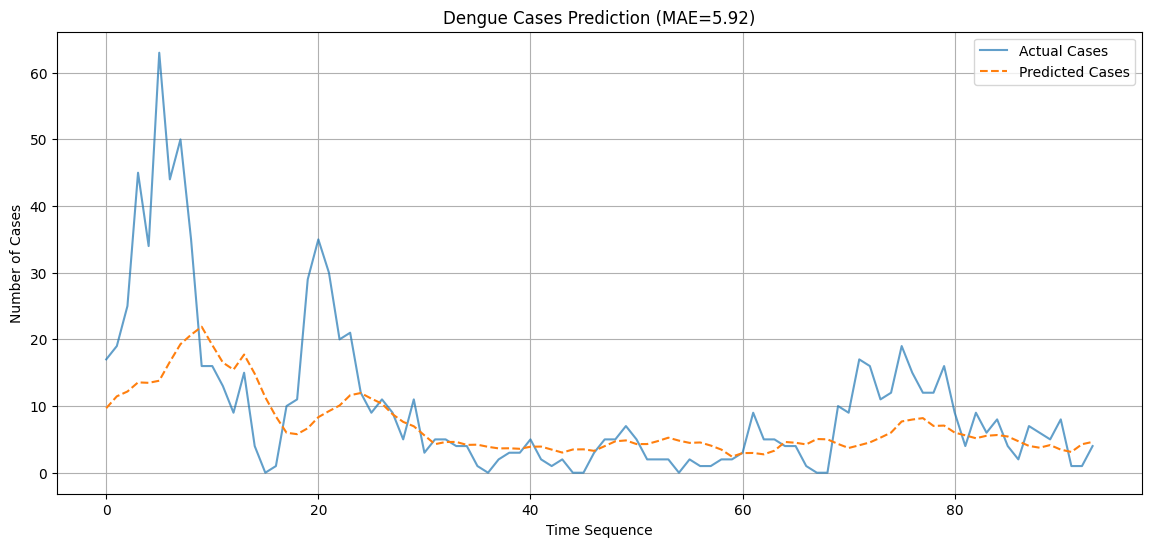

In [14]:
history = model.fit(
    X_train_scaled, y_train_scaled,
    epochs=100,
    validation_data=(X_val_scaled, y_val_scaled),
    callbacks=[early_stop],
    batch_size = 32, 
    verbose=0
)

test_predict = model.predict(X_val_scaled)

y_pred = scaler_y.inverse_transform(test_predict)
y_true = scaler_y.inverse_transform(y_val_scaled.reshape(-1,1))

mae = mean_absolute_error(y_true, y_pred)

plt.figure(figsize=(14, 6))
plt.plot(y_true, label="Actual Cases", alpha=0.7)
plt.plot(y_pred, label="Predicted Cases", linestyle='--')
plt.title(f"Dengue Cases Prediction (MAE={mae:.2f})")
plt.xlabel("Time Sequence")
plt.ylabel("Number of Cases")
plt.legend()
plt.grid(True)
plt.show()

c:\Users\13084\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\13084\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\13084\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\13084\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\13084\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\13084\

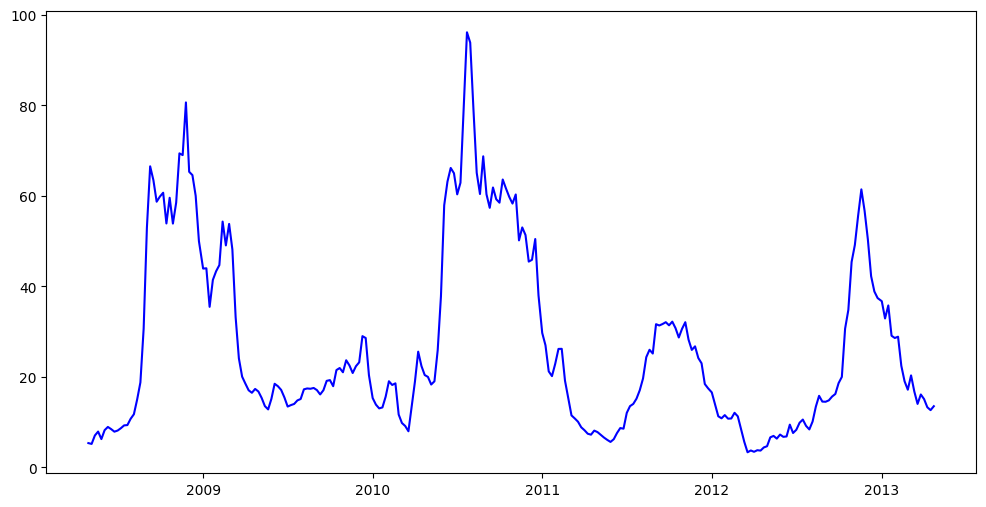

In [ ]:
future_climate_path = os.path.join("..", "data", "processed", "iq_future.csv")
future_climate = pd.read_csv(future_climate_path, parse_dates=['week_start_date'])
future_climate.set_index('week_start_date', inplace=True)
n_future_weeks = len(future_climate)

current_window = historical_data.iloc[-window_size:].copy()
predicted_cases = []

for i in range(n_future_weeks):
    window_scaled = scaler_X.transform(current_window)
    window_scaled_3d = window_scaled.reshape(1, window_size, n_features)
    
    y_pred_scaled = model.predict(window_scaled_3d, verbose=0)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)[0][0]
    predicted_cases.append(y_pred)
    
    new_row = future_climate.iloc[i][['ndvi_ne', 'ndvi_nw', 'station_diur_temp_rng_c', "station_avg_temp_c", "ndvi_se", "ndvi_sw", "station_precip_mm", "station_max_temp_c", "station_min_temp_c", "reanalysis_sat_precip_amt_mm", "reanalysis_relative_humidity_percent", "reanalysis_tdtr_k", "reanalysis_min_air_temp_k", "reanalysis_precip_amt_kg_per_m2", "reanalysis_max_air_temp_k", "reanalysis_avg_temp_k", "reanalysis_air_temp_k", "dew_humidity"]].values
    new_row = np.insert(new_row, 0, y_pred)
    current_window = pd.concat([
        current_window.iloc[1:],
        pd.DataFrame([new_row], columns=current_window.columns)
    ], ignore_index=True)

future_dates = future_climate.index
result = pd.DataFrame({'date': future_dates, 'predicted_cases': predicted_cases})
result.set_index('date', inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(result.index, result["predicted_cases"], label="Historical Cases", color="blue")

In [10]:
iq_final_model_path = os.path.join("..", "model", "iq_dengue_lstm_model.h5")
iq_final_model = load_model(iq_final_model_path, custom_objects={'mae': MeanAbsoluteError()})

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


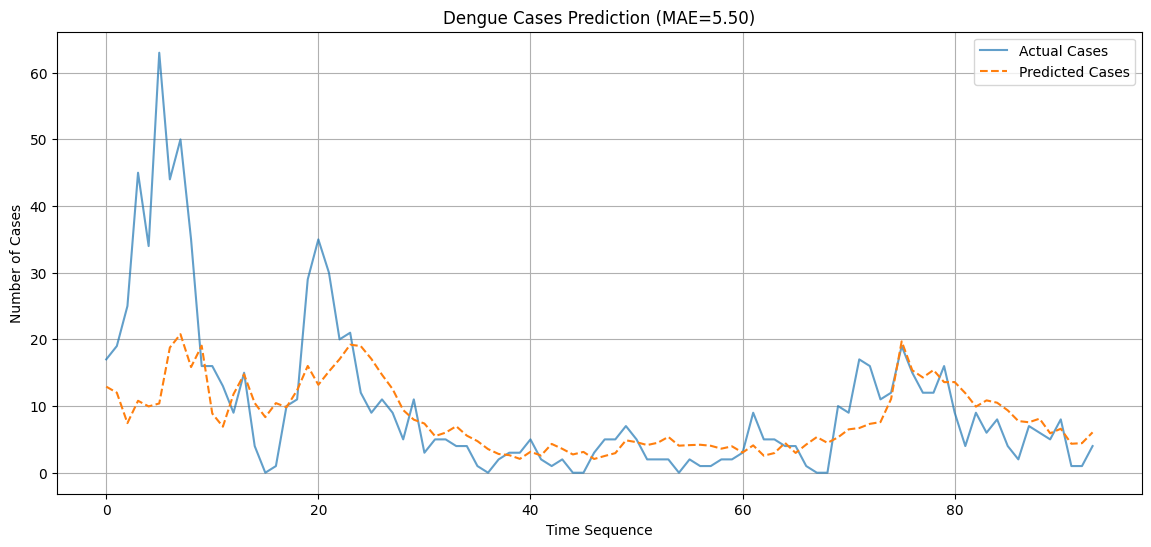

In [15]:
test_predict = iq_final_model.predict(X_val_scaled)

y_pred = scaler_y.inverse_transform(test_predict)
y_true = scaler_y.inverse_transform(y_val_scaled.reshape(-1,1))

mae = mean_absolute_error(y_true, y_pred)

plt.figure(figsize=(14, 6))
plt.plot(y_true, label="Actual Cases", alpha=0.7)
plt.plot(y_pred, label="Predicted Cases", linestyle='--')
plt.title(f"Dengue Cases Prediction (MAE={mae:.2f})")
plt.xlabel("Time Sequence")
plt.ylabel("Number of Cases")
plt.legend()
plt.grid(True)
plt.show()

c:\Users\13084\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\13084\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\13084\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\13084\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\13084\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\13084\

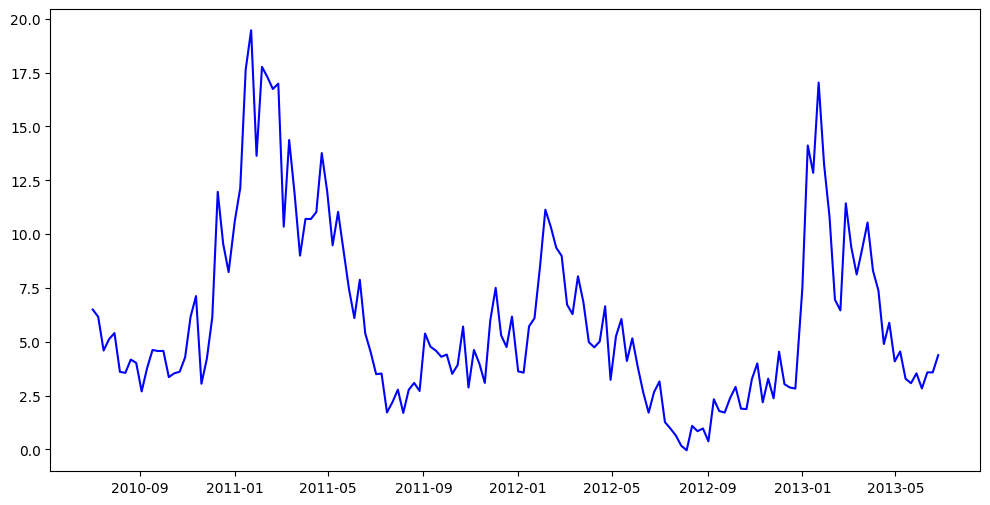

In [16]:
future_climate_path = os.path.join("..", "data", "processed", "iq_future.csv")
future_climate = pd.read_csv(future_climate_path, parse_dates=['week_start_date'])
future_climate.set_index('week_start_date', inplace=True)
n_future_weeks = len(future_climate)

current_window = historical_data.iloc[-window_size:].copy()
predicted_cases = []

for i in range(n_future_weeks):
    window_scaled = scaler_X.transform(current_window)
    window_scaled_3d = window_scaled.reshape(1, window_size, n_features)
    
    y_pred_scaled = iq_final_model.predict(window_scaled_3d, verbose=0)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)[0][0]
    predicted_cases.append(y_pred)
    
    new_row = future_climate.iloc[i][['ndvi_ne', 'ndvi_nw', 'station_diur_temp_rng_c', "station_avg_temp_c", "ndvi_se", "ndvi_sw", "station_precip_mm", "station_max_temp_c", "station_min_temp_c", "reanalysis_sat_precip_amt_mm", "reanalysis_relative_humidity_percent", "reanalysis_tdtr_k", "reanalysis_min_air_temp_k", "reanalysis_precip_amt_kg_per_m2", "reanalysis_max_air_temp_k", "reanalysis_avg_temp_k", "reanalysis_air_temp_k", "dew_humidity"]].values
    new_row = np.insert(new_row, 0, y_pred)
    current_window = pd.concat([
        current_window.iloc[1:],
        pd.DataFrame([new_row], columns=current_window.columns)
    ], ignore_index=True)

future_dates = future_climate.index
result = pd.DataFrame({'date': future_dates, 'predicted_cases': predicted_cases})
result.set_index('date', inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(result.index, result["predicted_cases"], label="Historical Cases", color="blue")